In [0]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [2]:
# В качестве набора данных будем использовать отзывы с сайта amazon
mob = pd.read_csv('Amazon_Unlocked_Mobile.csv', sep=",", encoding='ISO-8859-1')
mob.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [3]:
mob.shape

(413840, 6)

PromptCloud extracted more than 400 thousand reviews of unlocked mobile phones sold on Amazon.com to find out insights with respect to reviews, ratings, price and their relationships.

In [4]:
# Уникальные значения признака Review Votes
mob['Review Votes'].unique()

array([  1.,   0.,   2.,   6.,  19.,  12.,  13.,  17.,   4.,   9.,   3.,
         5.,  16.,   7.,  11.,  15.,   8.,  23.,  14.,  20.,  24.,  nan,
        18.,  10.,  41.,  59.,  42., 116.,  22.,  57.,  21.,  32.,  54.,
        30.,  77., 115.,  39.,  31.,  64., 124.,  36., 100., 125.,  28.,
        86.,  25.,  43.,  27., 120.,  72., 121.,  48.,  33.,  75.,  40.,
        37., 249.,  38., 130., 112., 157.,  51.,  58.,  63., 107.,  52.,
        34.,  46.,  45.,  85., 105., 366.,  29., 138.,  67.,  62.,  35.,
        47., 177.,  80.,  66.,  68.,  84., 152.,  53., 113., 151., 141.,
       159., 128.,  94.,  79.,  56.,  78.,  55.,  61.,  50.,  76., 127.,
        96., 119.,  87.,  60., 192.,  44.,  49., 126.,  26.,  81.,  88.,
       158.,  92., 155., 154., 156., 106., 175., 103., 172., 118.,  83.,
       296., 136.,  73.,  74.,  90.,  65., 283., 282., 288., 285., 270.,
       265., 478., 462., 465., 171.,  98.,  99., 169., 213., 110., 183.,
        71., 109., 114., 182., 221., 487., 170.,  9

In [5]:
# Уникальные значения признака Rating
# Будем использовать этот признак для определения характеристик текста
mob['Rating'].unique()

array([5, 4, 1, 2, 3])

In [6]:
mob.isna().sum()

Product Name        0
Brand Name      65171
Price            5933
Rating              0
Reviews            62
Review Votes    12296
dtype: int64

In [0]:
# Удалим строки с пропусками данных, 
# так как их количество существенно меньше размера датасета и не отразится на качестве модели
mob.dropna(inplace=True)

In [8]:
mob.shape

(334335, 6)

Рассмотрим, как рейтинг мобильных устройств влияет на длину отзывов

1 - mean: 247.22681845832972
2 - mean: 330.6330476380307
3 - mean: 296.54532197405786
4 - mean: 274.9803058249539
5 - mean: 169.16030246375928


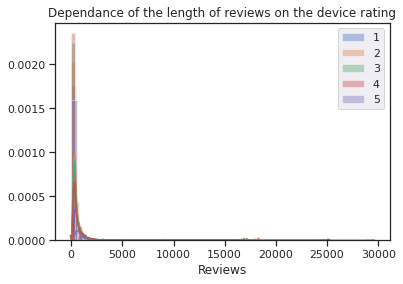

In [9]:
s1 = mob[mob.Rating == 1].Reviews.apply(len)
s2 = mob[mob.Rating == 2].Reviews.apply(len)
s3 = mob[mob.Rating == 3].Reviews.apply(len)
s4 = mob[mob.Rating == 4].Reviews.apply(len)
s5 = mob[mob.Rating == 5].Reviews.apply(len)

sns.distplot(s1,label='1')
sns.distplot(s2,label='2')
sns.distplot(s3,label='3')
sns.distplot(s4,label='4')
sns.distplot(s5,label='5')

sns.set()

plt.title('Dependance of the length of reviews on the device rating')
plt.legend()

print('1 - mean: %s' % s1.mean())
print('2 - mean: %s' % s2.mean())
print('3 - mean: %s' % s3.mean())
print('4 - mean: %s' % s4.mean())
print('5 - mean: %s' % s5.mean())

Как видно из графика, негативные отзывы (для товаров с рейтингом 1,2) превышают положительные отзывы (для устройств с рейтингом 4,5) по длине.

In [0]:
# Разделим данные на обучающую и тестовую выборки
X = mob.Reviews
y = mob.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
# Сформируем общий словарь для обучения моделей из обучающей и тестовой выборки
vocab_list = mob['Reviews'].tolist()
vocab_list[1:10]

['nice phone, nice up grade from my pantach revue. Very clean set up and easy set up. never had an android phone but they are fantastic to say the least. perfect size for surfing and social media. great phone samsung',
 'Very pleased',
 'It works good but it goes slow sometimes but its a very good phone I love it',
 'Great phone to replace my lost phone. The only thing is the volume up button does not work, but I can still go into settings to adjust. Other than that, it does the job until I am eligible to upgrade my phone again.Thaanks!',
 'I already had a phone with problems... I know it stated it was used, but dang, it did not state that it did not charge. I wish I would have read these comments then I would have not purchased this item.... and its cracked on the side.. damaged goods is what it is.... If trying to charge it another way does not work I am requesting for my money back... AND I WILL GET MY MONEY BACK...SIGNED AN UNHAPPY CUSTOMER....',
 'The charging port was loose. I go

In [12]:
vocabVect = CountVectorizer()
vocabVect.fit(vocab_list)
corpusVocab = vocabVect.vocabulary_
print('Количество сформированных признаков - {}'.format(len(corpusVocab)))

Количество сформированных признаков - 63516


In [13]:
for i in list(corpusVocab)[1:10]:
    print('{}={}'.format(i, corpusVocab[i]))

so=52056
lucky=34179
to=56818
have=27444
found=24315
this=56266
used=59467
phone=41769
us=59365


Проведём векторизацию текста

In [14]:
# Класс TfidfVectorizer вычисляет специфичность текста в корпусе текстов на основе метрики TF-IDF
tfidfv = TfidfVectorizer(ngram_range=(1,3))
tfidf_ngram_features = tfidfv.fit_transform(vocab_list)
tfidf_ngram_features

<334335x4204950 sparse matrix of type '<class 'numpy.float64'>'
	with 33222615 stored elements in Compressed Sparse Row format>

В качестве классификаторов будем использовать Multinomial Naive Bayes (MNB) и LogisticRegression

In [0]:
clf1 = Pipeline([('tfidfv', tfidfv), ('MultinomNB', MultinomialNB()),])
clf2 = Pipeline([('tfidfv', tfidfv), ('LogRegr', LogisticRegression()),])

Multinomial Naive Bayes (MNB)

In [28]:
%time 
clf1.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 44.1 µs


Pipeline(memory=None,
         steps=[('tfidfv',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('MultinomNB',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

Метрики точности accuracy_score, precision_score, recall_score

In [31]:
print('accuracy_score (train):', accuracy_score(y_train, clf1.predict(X_train)))
print('accuracy_score (test):', accuracy_score(y_test, clf1.predict(X_test)))

accuracy_score (train): 0.6868831024551988
accuracy_score (test): 0.6610901187425848


In [36]:
print('precision_score (train):', precision_score(y_train, clf1.predict(X_train), average='micro'))
print('precision_score (test):', precision_score(y_test, clf1.predict(X_test), average='micro'))

precision_score (train): 0.6868831024551988
precision_score (test): 0.6610901187425848


In [39]:
print('recall_score (train):', recall_score(y_train, clf1.predict(X_train), average='micro'))
print('recall_score (test):', recall_score(y_test, clf1.predict(X_test), average='micro'))

recall_score (train): 0.6868831024551988
recall_score (test): 0.6610901187425848


LogisticRegression

In [40]:
%time 
clf2.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('tfidfv',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('LogRegr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_sc

Метрики точности accuracy_score, precision_score, recall_score

In [44]:
print('accuracy_score (train):', accuracy_score(y_train, clf2.predict(X_train)))
print('accuracy_score (test):', accuracy_score(y_test, clf2.predict(X_test)))

accuracy_score (train): 0.841189741661468
accuracy_score (test): 0.7975992263287505


In [45]:
print('precision_score (train):', precision_score(y_train, clf2.predict(X_train), average='micro'))
print('precision_score (test):', precision_score(y_test, clf2.predict(X_test), average='micro'))

precision_score (train): 0.841189741661468
precision_score (test): 0.7975992263287505


In [46]:
print('recall_score (train):', recall_score(y_train, clf2.predict(X_train), average='micro'))
print('recall_score (test):', recall_score(y_test, clf2.predict(X_test), average='micro'))

recall_score (train): 0.841189741661468
recall_score (test): 0.7975992263287505


Таким образом, на основании полученных с помощью метрик accuracy, precision_score и recall_score результатов о качестве классификаций, можно сделать вывод о том, что для выбранного набора данных классификатор LogisticRegression осуществляет более качественную классификацию данных.